# Cake Eating: Numerical Methods

```{include} _admonition/gpu.md
```

This lecture is the extended JAX implementation of [this lecture](https://python.quantecon.org/cake_eating_numerical.html).

Please refer that lecture for all background and notation.

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

We will use the following imports.

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from collections import namedtuple
import time

Let's check the GPU we are running

In [3]:
!nvidia-smi

/opt/conda/envs/quantecon/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Thu Mar  7 01:45:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0    38W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


## Reviewing the Model

Recall in particular that the Bellman equation is

```{math}
:label: bellman-cen

v(x) = \max_{0\leq c \leq x} \{u(c) + \beta v(x-c)\}
\quad \text{for all } x \geq 0.
```

where $u$ is the CRRA utility function.


## Implementation using JAX


The analytical solutions for the value function and optimal policy were found
to be as follows.

In [4]:
@jax.jit
def c_star(x, β, γ):
    return (1 - β ** (1/γ)) * x

@jax.jit
def v_star(x, β, γ):
    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

Let's define a model to represent the Cake Eating Problem.

In [5]:
CEM = namedtuple('CakeEatingModel',
                    ('β', 'γ', 'x_grid', 'c_grid'))

In [6]:
def create_cake_eating_model(β=0.96,           # discount factor
                             γ=1.5,            # degree of relative risk aversion
                             x_grid_min=1e-3,  # exclude zero for numerical stability
                             x_grid_max=2.5,   # size of cake
                             x_grid_size=200):
    x_grid = jnp.linspace(x_grid_min, x_grid_max, x_grid_size)

    # c_grid used for finding maximize function values using brute force
    c_grid = jnp.linspace(x_grid_min, x_grid_max, 100*x_grid_size)
    return CEM(β=β, γ=γ, x_grid=x_grid, c_grid=c_grid)

Now let's define the CRRA utility function.

In [7]:
# Utility function
@jax.jit
def u(c, cem):
    return (c ** (1 - cem.γ)) / (1 - cem.γ)

### The Bellman Operator

We introduce the **Bellman operator** $T$ that takes a function v as an
argument and returns a new function $Tv$ defined by

$$
Tv(x) = \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

From $v$ we get $Tv$, and applying $T$ to this yields
$T^2 v := T (Tv)$ and so on.

This is called **iterating with the Bellman operator** from initial guess
$v$.

In [8]:
@jax.jit
def state_action_value(x, c, v_array, ce):
    """
    Right hand side of the Bellman equation given x and c.
    * x: scalar element `x`
    * c: c_grid, 1-D array
    * v_array: value function array guess, 1-D array
    * ce: Cake Eating Model instance
    """

    return jnp.where(c <= x,
                     u(c, ce) + ce.β * jnp.interp(x - c, ce.x_grid, v_array),
                     -jnp.inf)

In order to create a vectorized function using `state_action_value`, we use [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html).
This function returns a new vectorized version of the above function which is vectorized on the argument `x`.

In [9]:
state_action_value_vec = jax.vmap(state_action_value, (0, None, None, None))

In [10]:
@jax.jit
def T(v, ce):
    """
    The Bellman operator. Updates the guess of the value function.

    * ce: Cake Eating Model instance
    * v: value function array guess, 1-D array

    """
    return jnp.max(state_action_value_vec(ce.x_grid, ce.c_grid, v, ce), axis=1)

Let’s start by creating a Cake Eating Model instance using the default parameterization.

In [11]:
ce = create_cake_eating_model()

Now let's see the iteration of the value function in action.

We start from guess $v$ given by $v(x) = u(x)$ for every
$x$ grid point.

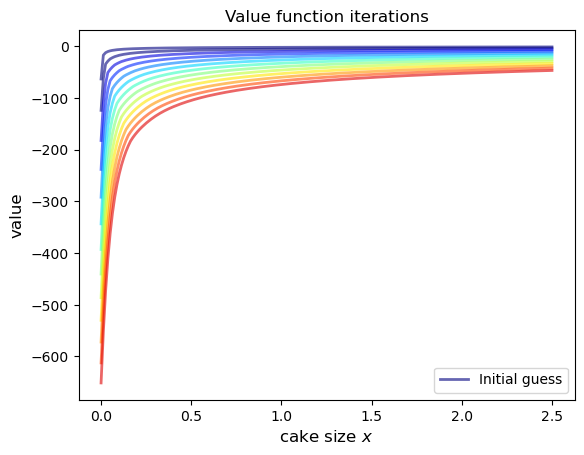

In [12]:
x_grid = ce.x_grid
v = u(x_grid, ce)       # Initial guess
n = 12                 # Number of iterations

fig, ax = plt.subplots()

ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

for i in range(n):
    v = T(v, ce)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')

plt.show()

Let's introduce a wrapper function called `compute_value_function`
that iterates until some convergence conditions are satisfied.

In [13]:
def compute_value_function(ce,
                           tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=25):

    # Set up loop
    v = jnp.zeros(len(ce.x_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, ce)

        error = jnp.max(jnp.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [14]:
in_time = time.time()
v_jax = compute_value_function(ce)
jax_time = time.time() - in_time

Error at iteration 25 is 23.74322509765625.
Error at iteration 50 is 8.5570068359375.
Error at iteration 75 is 3.083984375.


Error at iteration 100 is 1.11151123046875.
Error at iteration 125 is 0.40069580078125.
Error at iteration 150 is 0.14447021484375.


Error at iteration 175 is 0.0521240234375.
Error at iteration 200 is 0.01885986328125.
Error at iteration 225 is 0.006866455078125.


Error at iteration 250 is 0.0025634765625.
Error at iteration 275 is 0.0009765625.
Error at iteration 300 is 0.00048828125.


Error at iteration 325 is 0.000244140625.
Error at iteration 350 is 0.0001220703125.

Converged in 351 iterations.


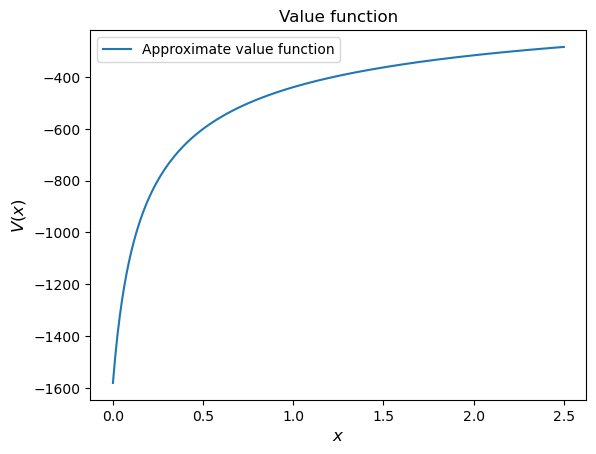

In [15]:
fig, ax = plt.subplots()

ax.plot(x_grid, v_jax, label='Approximate value function')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

Next let’s compare it to the analytical solution.

In [16]:
v_analytical = v_star(ce.x_grid, ce.β, ce.γ)

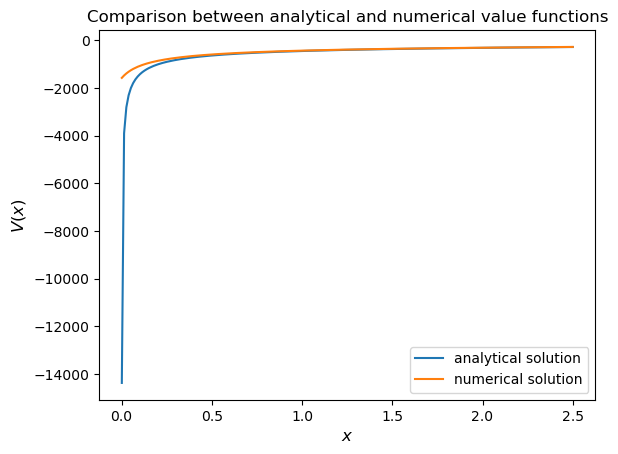

In [17]:
fig, ax = plt.subplots()

ax.plot(x_grid, v_analytical, label='analytical solution')
ax.plot(x_grid, v_jax, label='numerical solution')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.legend()
ax.set_title('Comparison between analytical and numerical value functions')
plt.show()

### Policy Function

Recall that the optimal consumption policy was shown to be

$$
\sigma^*(x) = \left(1-\beta^{1/\gamma} \right) x
$$

Let's see if our numerical results lead to something similar.

Our numerical strategy will be to compute

$$
\sigma(x) = \arg \max_{0 \leq c \leq x} \{u(c) + \beta v(x - c)\}
$$

on a grid of $x$ points and then interpolate.

For $v$ we will use the approximation of the value function we obtained
above.

Here's the function:

In [18]:
@jax.jit
def σ(ce, v):
    """
    The optimal policy function. Given the value function,
    it finds optimal consumption in each state.

    * ce: Cake Eating Model instance
    * v: value function array guess, 1-D array

    """
    i_cs =  jnp.argmax(state_action_value_vec(ce.x_grid, ce.c_grid, v, ce), axis=1)
    return ce.c_grid[i_cs]

Now let’s pass the approximate value function and compute optimal consumption:

In [19]:
c = σ(ce, v_jax)

Let’s plot this next to the true analytical solution

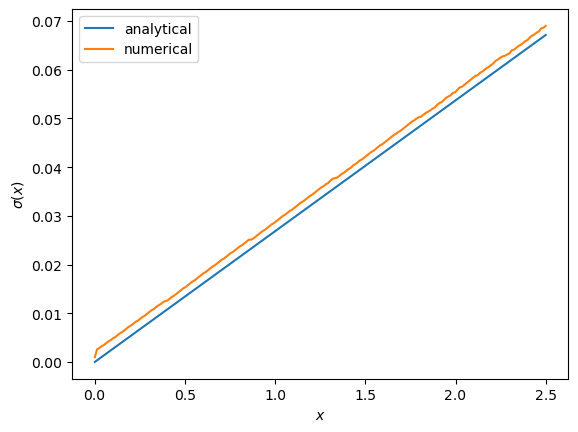

In [20]:
c_analytical = c_star(ce.x_grid, ce.β, ce.γ)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical')
ax.plot(ce.x_grid, c, label='numerical')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlabel('$x$')
ax.legend()

plt.show()

## Numba implementation

This section of the lecture is directly adapted from [this lecture](https://python.quantecon.org/cake_eating_numerical.html)
for the purpose of comparing the results of JAX implementation.

In [21]:
import numpy as np
from numba import prange, njit
from quantecon.optimize import brent_max

In [22]:
CEMN = namedtuple('CakeEatingModelNumba',
                    ('β', 'γ', 'x_grid'))

In [23]:
def create_cake_eating_model_numba(β=0.96,           # discount factor
                                   γ=1.5,            # degree of relative risk aversion
                                   x_grid_min=1e-3,  # exclude zero for numerical stability
                                   x_grid_max=2.5,   # size of cake
                                   x_grid_size=200):
    x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)
    return CEMN(β=β, γ=γ, x_grid=x_grid)

In [24]:
# Utility function
@njit
def u_numba(c, cem):
    return (c ** (1 - cem.γ)) / (1 - cem.γ)

In [25]:
@njit
def state_action_value_numba(c, x, v_array, cem):
    """
    Right hand side of the Bellman equation given x and c.
    * x: scalar element `x`
    * c: consumption
    * v_array: value function array guess, 1-D array
    * cem: Cake Eating Numba Model instance
    """
    return u_numba(c, cem) + cem.β * np.interp(x - c, cem.x_grid, v_array)

In [26]:
@njit
def T_numba(v, ce):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEatingNumba Model
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i in prange(len(ce.x_grid)):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = brent_max(state_action_value_numba, 1e-10, ce.x_grid[i],
                             args=(ce.x_grid[i], v, ce))[1]
    return v_new

In [27]:
def compute_value_function_numba(ce,
                           tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=25):

    # Set up loop
    v = np.zeros(len(ce.x_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T_numba(v, ce)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [28]:
cen = create_cake_eating_model_numba()

In [29]:
in_time = time.time()
v_np = compute_value_function_numba(cen)
numba_time = time.time() - in_time

Error at iteration 25 is 23.8003755134813.
Error at iteration 50 is 8.577577195046615.
Error at iteration 75 is 3.091330659691039.
Error at iteration 100 is 1.1141054204751981.
Error at iteration 125 is 0.4015199357729671.
Error at iteration 150 is 0.14470646660583952.
Error at iteration 175 is 0.05215173547298946.
Error at iteration 200 is 0.018795314243106986.


Error at iteration 225 is 0.006773769545986852.
Error at iteration 250 is 0.002441244305884993.
Error at iteration 275 is 0.0008798164334962166.
Error at iteration 300 is 0.00031708295477983484.
Error at iteration 325 is 0.00011427565664234862.

Converged in 329 iterations.


In [30]:
ratio = numba_time/jax_time
print(f"JAX implementation is {ratio} times faster than NumPy.")
print(f"JAX time: {jax_time}")
print(f"Numba time: {numba_time}")

JAX implementation is 2.587911676343642 times faster than NumPy.
JAX time: 1.177682876586914
Numba time: 3.047739267349243
